We will be using Google's Analytic 360 Data obfuscated sample data from the Google Merchandise store on their BigQuery Rest API. The sample dataset provides 12 months (August 2016 to August 2017), however we will only be focusing on 1 of those months within the data set (July 1, 2017 to July 31, 2017).

The [overview](https://console.cloud.google.com/marketplace/product/obfuscated-ga360-data/obfuscated-ga360-data?project=lexical-script-761) describes the data as typical of what an ecommerce website would see and includes the following information:

- Traffic source data
- Content data
- Transactional data

Constraints: 

1. All users have view access to the dataset and can only query the dataset and generate reports 
2. Data for some fields is obfuscated such as _fullVisitorId_
3. Data for some field is removed such as _clientId_, _adWordsClickInfo_ and _geoNetwork_  
4. “Not available in demo dataset” will be returned for STRING values 
5. “null” will be returned for INTEGER values when querying the fields containing no data

## PROBLEM: 
___How can we determine a customer's propensity to buy based on their behaviors in multiple sessions over the days or weeks prior to a transaction in the scope of 1 month?___

## SET-UP

To use BigQuery, you will need to sign up for an account and get an API key. Follow the instructions here for [quick start](https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries) and [authentication](https://cloud.google.com/docs/authentication/getting-started#cloud-console).

In [93]:
# Load the "autoreload" extension
#%load_ext autoreload

#reload extension
%reload_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

#Import all the necessary packages to query from the BigQuery Rest API
import os
import sys
from google.cloud import bigquery

# add the 'python' directory as one where we can import modules
py_dir = os.path.join(os.getcwd(), 'python')

# import my method from the source code
from python.get_info import plot_hists, get_missing_data

#Import all necessary packages for visualization and transformation of the data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [94]:
#access BigQuery with your personal API key
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="api_key.json"
client = bigquery.Client()

In [5]:
#preview the data
query = ''' SELECT * 
            FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801` 
            LIMIT 100'''
sample = client.query(query).to_dataframe()

In [6]:
sample.head()

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,NaN,1,1501583974,1501583974,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Car...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2248281639583218707,None,None,Organic Search,Not Socially Engaged
1,NaN,1,1501616585,1501616585,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8647436381089107732,None,None,Organic Search,Not Socially Engaged
2,NaN,1,1501583344,1501583344,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2055839700856389632,None,None,Organic Search,Not Socially Engaged
3,NaN,1,1501573386,1501573386,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 0, 'minut...",0750846065342433129,None,None,Direct,Not Socially Engaged
4,NaN,8,1501651467,1501651467,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 22, 'minu...",0573427169410921198,None,None,Organic Search,Not Socially Engaged


## EXPLORING FEATURES

### fullVisitorId and date

To identify each unique visitor regardless of what day they visit on, we will be using __fullVisitorId__. 

__clientId__ and __userId__ have been deprecated and __visitId__ is only an identifier for each session. We want a high-level overview of each unique visitor's behavior over multiple sessions.

Because we are concerned with transactions by day we will use __date__. Again, we will not use __visitStartTime__ because this records the start of each session and we want to observe behavior over multiple sessions.

### Other features to explore

Because we are concerned by a customer's propensity to buy based on transactions and behaviors over multiple sessions by days and weeks, we will need to explore the __totals__ and __hits__ column.

We will also look at __trafficSource__, __device__, __channelGrouping__, and __geoNetwork__ to get a sense of the constraints in the data and if we can use for further analysis by unsetting the data.

Based on the preview data __customDimensions__ looks like a duplicate column for __geoNetwork__ so we will not be exploring this further.

Because we only care about a high-level overview of whether or not visitors makes a purchase over a period of time and multiple sessions, we will not be looking at the __socialEngagementType__ or __visitNumber__ by each session (__visitNumber__ can be aggregated by the __visits__ feature nested in __totals__).

# MISSING DATA

For now, we will be querying a small random sample size of 1000 rows from August 1, 2017 to get a general idea of the kinds of features we have missing and available to us.

In [95]:
query = ''' SELECT *
            FROM UNNEST(ARRAY(SELECT totals
                              FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
                              WHERE _TABLE_SUFFIX BETWEEN '20170801' AND '20170801'
                              ORDER BY RAND() LIMIT 1000
            ))'''
totals_df = client.query(query).to_dataframe()
totals_df.head()

,visits,hits,pageviews,timeOnSite,bounces,transactions,transactionRevenue,newVisits,screenviews,uniqueScreenviews,timeOnScreen,totalTransactionRevenue,sessionQualityDim
0,1,2,2,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,1,1,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1
2,1,1,1,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1
3,1,1,1,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1
4,1,3,3,75.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1


In [96]:
get_missing_data(totals_df)

% of Missing Data:
visits                       0.0
hits                         0.0
pageviews                    0.0
timeOnSite                  46.1
bounces                     54.2
transactions                97.9
transactionRevenue          97.9
newVisits                   27.2
screenviews                100.0
uniqueScreenviews          100.0
timeOnScreen               100.0
totalTransactionRevenue     97.9
sessionQualityDim            0.0
dtype: float64



There is a lot of missing data, but this is normal as not every visitor purchases something on the page. 

Let's look at the distribution of each feature:

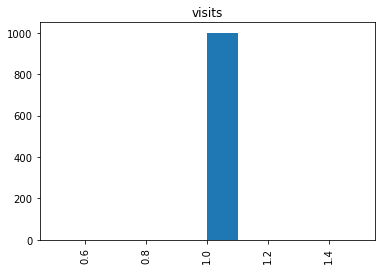

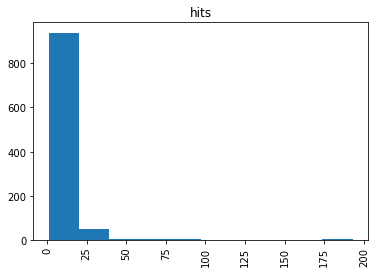

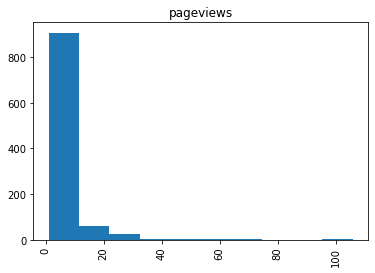

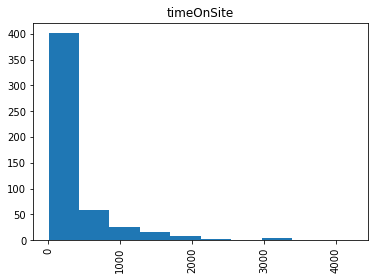

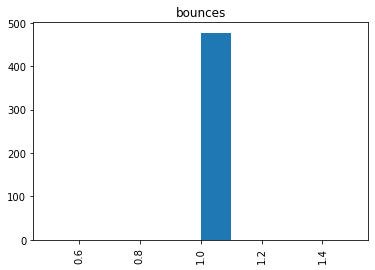

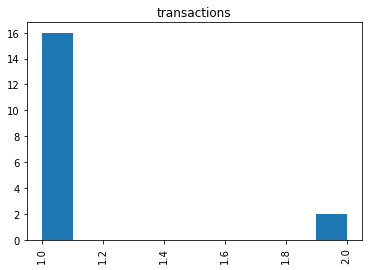

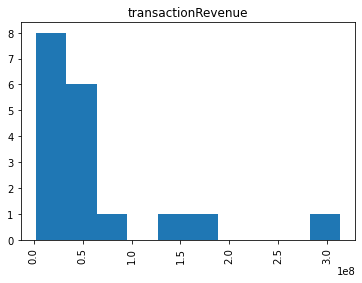

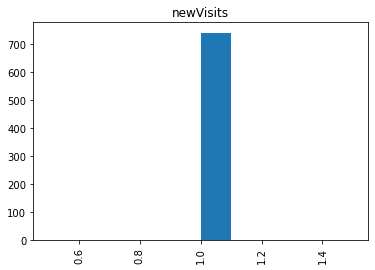

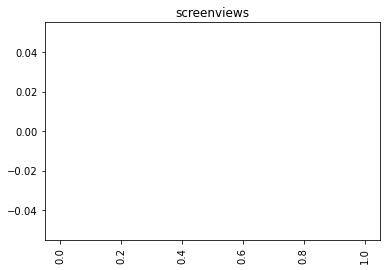

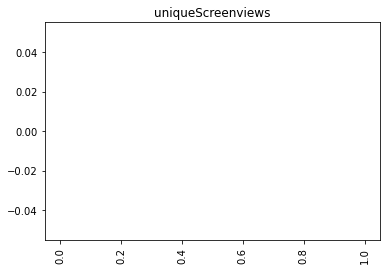

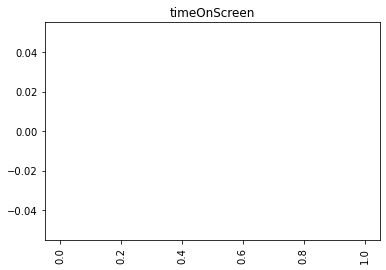

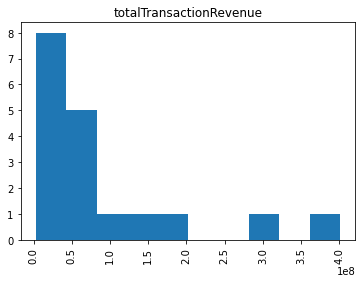

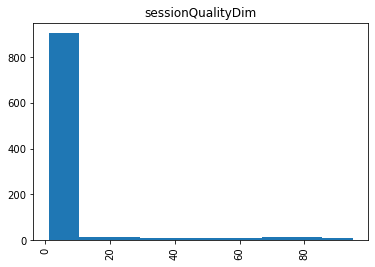

In [52]:
plot_hists(totals_df)

Based on the distribution of the features in the histogram, we can see that the only completely missing features from our random sample are __screenViews__, __uniqueScreenViews__, and __timeOnScreen__.

We can't disregard the missing data from the other features because these are indicators that a customer hasn't purchased or that the user has only interacted with one feature on the page.

Of these features the most useful could be the following:

- __visits__ - this represents the number of sessions
- __hits__ - total number of interactions within a session
- __pageviews__ - total number of pageviews in a session
- __bounces__ - total bounces. These trigger in the Analytics server if only a single interaction is made on the whole website
- __sessionQuality__ - an estimate of how close a particular estimate was close to transacting from 1 to 100 with 1 being the lowest session quality and 100 being close to transacting
- __timeOnSite__ - total time of the session in seconds

Based on the question we're trying to answer, we will be using __transactions__ to help us create our labels (whether or not a visitor buys or not).

We can aggregate these features by the fullVisitorId and dates to get a bigger picture of each visitors behavior over multiple sessions in a day. 

### TRAFFIC SOURCE

In [77]:
query ='''SELECT referralPath, campaign, source, medium, keyword, adContent, isTrueDirect, campaignCode, adwordsClickInfo                                 
          FROM UNNEST(ARRAY( SELECT trafficSource
                             FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
                             WHERE _TABLE_SUFFIX BETWEEN '20170801' AND '20170801'
                             ORDER BY RAND() LIMIT 1000
                            ))'''

trafficSource_df = client.query(query).to_dataframe()
get_missing_data(trafficSource_df)

% of Missing Data:
referralPath         73.9
campaign              0.0
source                0.0
medium                0.0
keyword              99.9
adContent            99.5
isTrueDirect         67.8
campaignCode        100.0
adwordsClickInfo      0.0
dtype: float64



In [35]:
trafficSource_df.head()

,referralPath,campaign,source,medium,keyword,adContent,isTrueDirect,campaignCode,adwordsClickInfo
0,/intl/ja/yt/about/,(not set),youtube.com,referral,None,None,None,None,"{'campaignId': None, 'adGroupId': None, 'creat..."
1,None,(not set),(direct),(none),None,None,None,None,"{'campaignId': None, 'adGroupId': None, 'creat..."
2,None,(not set),(direct),(none),None,None,True,None,"{'campaignId': None, 'adGroupId': None, 'creat..."
3,None,(not set),(direct),(none),None,None,True,None,"{'campaignId': None, 'adGroupId': None, 'creat..."
4,None,(not set),(direct),(none),None,None,None,None,"{'campaignId': None, 'adGroupId': None, 'creat..."


_adwordsClickInfo_ is also nested; we will need to unset this separately.

In [78]:
query='''SELECT campaignId, adGroupId, creativeId, criteriaId, page, slot, criteriaParameters,
         gclId, customerId, adNetworkType, targetingCriteria.boomUserlistId, isVideoAd
         FROM UNNEST(ARRAY(  SELECT adwordsClickInfo
                             FROM UNNEST(ARRAY( SELECT trafficSource
                                                FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
                                                WHERE _TABLE_SUFFIX BETWEEN '20170801' AND '20170801'
                                                ORDER BY RAND() LIMIT 1000
                                               ))))'''

trafficSource_ads_df = client.query(query).to_dataframe()
get_missing_data(trafficSource_ads_df)

% of Missing Data:
campaignId            100.0
adGroupId             100.0
creativeId            100.0
criteriaId            100.0
page                   98.3
slot                   98.3
criteriaParameters      0.0
gclId                  98.3
customerId            100.0
adNetworkType          98.3
boomUserlistId        100.0
isVideoAd              98.3
dtype: float64



As expected, there is a lot of missing data for __trafficSource__ that's been removed from the sample dataset.
However, because we only care about customer propensity once a visitor is in Google Marketplace and not customer journey, we will not be using this feature for this project.

### DEVICE

In [79]:
query ='''SELECT *
          FROM UNNEST(ARRAY(  SELECT device
                              FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
                              WHERE _TABLE_SUFFIX BETWEEN '20170801' AND '20170801'
                              ORDER BY RAND() LIMIT 1000
                            ))'''

device_df = client.query(query).to_dataframe()
get_missing_data(device_df)

% of Missing Data:
browser                        0.0
browserVersion                 0.0
browserSize                    0.0
operatingSystem                0.0
operatingSystemVersion         0.0
isMobile                       0.0
mobileDeviceBranding           0.0
mobileDeviceModel              0.0
mobileInputSelector            0.0
mobileDeviceInfo               0.0
mobileDeviceMarketingName      0.0
flashVersion                   0.0
javaEnabled                  100.0
language                       0.0
screenColors                   0.0
screenResolution               0.0
deviceCategory                 0.0
dtype: float64



So far it looks like there is a lot of information under __device__. Let's double check by previewing the column first.

In [81]:
device_df.head()

,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,javaEnabled,language,screenColors,screenResolution,deviceCategory
0,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,None,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile
1,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,None,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
2,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,None,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
3,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,None,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
4,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,None,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop


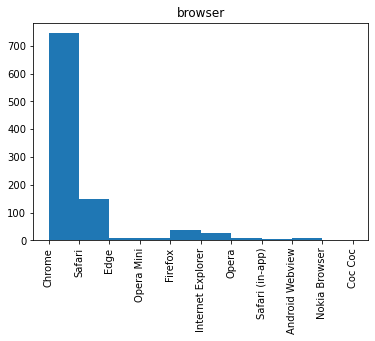

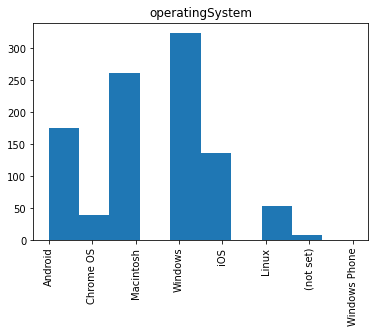

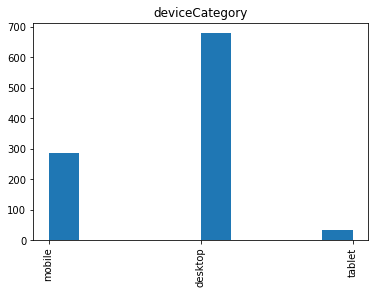

In [88]:
plot_hists(device_df.iloc[:, [0, 3, -1]])

A lot of information isn't available for mobile device, other than determining the __deviceCategory__, __browser_, __operatingSystem__ and __isMobile__. However, because we only care about customer propensity once a visitor is in Google Marketplace and not customer journey, we will not be using the __device__ feature for this project. It is interesting to note that most interactions happen on Desktop using Google Chrome.

### geoNetwork

In [82]:
query ='''SELECT *
          FROM UNNEST(ARRAY( SELECT
                             geoNetwork
                             FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
                             WHERE _TABLE_SUFFIX BETWEEN '20170801' AND '20170801'
                             ORDER BY RAND() LIMIT 1000
                              ))'''

geoNetwork_df = client.query(query).to_dataframe()
get_missing_data(geoNetwork_df)

% of Missing Data:
continent          0.0
subContinent       0.0
country            0.0
region             0.0
metro              0.0
city               0.0
cityId             0.0
networkDomain      0.0
latitude           0.0
longitude          0.0
networkLocation    0.0
dtype: float64



It looks like there isn't any missing data. However, one of our constraints note that there is. We need to preview the data in this case.

In [49]:
geoNetwork_df.head()

,continent,subContinent,country,region,metro,city,cityId,networkDomain,latitude,longitude,networkLocation
0,Asia,Southern Asia,Pakistan,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset
1,Asia,Southern Asia,India,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset
2,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset
3,Americas,Northern America,United States,New York,New York NY,New York,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset
4,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,kabel-badenwuerttemberg.de,not available in demo dataset,not available in demo dataset,not available in demo dataset


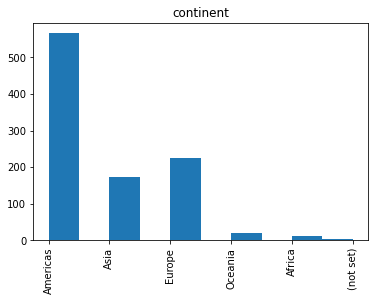

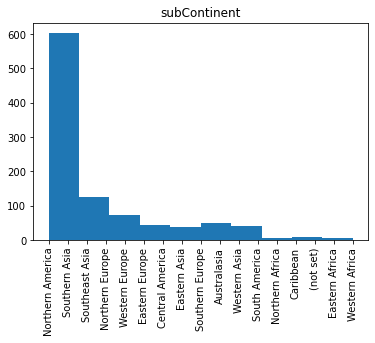

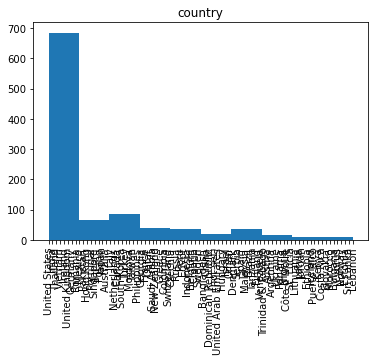

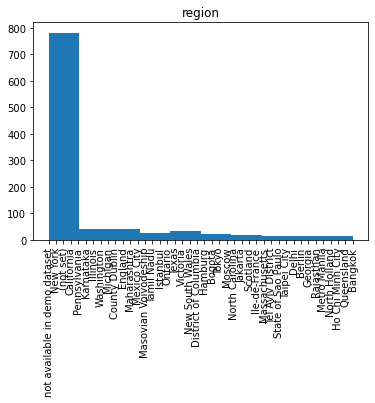

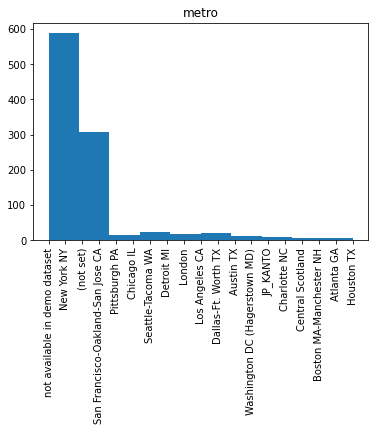

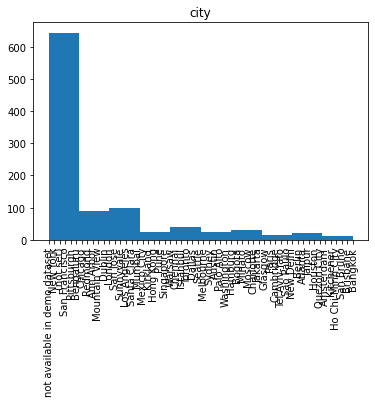

In [84]:
plot_hists(geoNetwork_df.iloc[:,:6])

As noted in the description overview, most of these features are 'not available in demo dataset'. Furthermore, because we care about _all_ transactions regardless of location or region, there is no need to view or breakout this feature for our project. Based on the information we have however, most visitors are based in the U.S.

### Hits

We need to unnest __hits__ to take a closer look at the features.

In [66]:
query = ''' SELECT *
            FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits)
            WHERE _TABLE_SUFFIX BETWEEN '20170801' AND '20170801'
            ORDER BY RAND() LIMIT 1000
                '''
hits_df = client.query(query).to_dataframe()

This query will unnest all hits and also call all the higher levels features that we have viewed previously (__fullVisitorId__, __trafficSource__, __geoNetwork__, etc) so we will only look at the new features. 

In [71]:
hits_df = hits_df.iloc[:,10:]

In [75]:
hits_df[0:2].T.head(40)

,0,1
hits,"[{'hitNumber': 1, 'time': 0, 'hour': 11, 'minu...","[{'hitNumber': 1, 'time': 0, 'hour': 14, 'minu..."
fullVisitorId,0815047945706399620,8016003971239765913
userId,None,None
clientId,None,None
channelGrouping,Referral,Referral
socialEngagementType,Not Socially Engaged,Not Socially Engaged
hitNumber,4,86
time,34802,1548768
hour,11,15
minute,43,5


Based on the overview of these features, we can see most are unrelated to the question we are trying to answer, are duplicates or redundant information (__hits__, __fullVisitorId__, __channelGrouping__, __hitNumber__, etc) or are related to customer journey analysis (__isEntrance__, __isExit__, __dataSource__, __appInfo__, __eventInfo__, etc).

These features would be considered the most useful if they weren't also redundant to the __totals__ column:

- __isInteraction__ - we can determine total number of interactions by aggregating total hits under __totals.hits__
- __transaction__ - we can determine if a transaction is made by aggregating total transactions greater than 1
- __item__ - we care about all transactions regardless of item type and only need a high-level overview of all transactions
- __product__ - we care about all transactions regardless of product type and only need a high-level overview of all transactions
- __eCommerceAction__ - we can determine if a transaction is made by aggregating total transactions greater than 1

### Channel Grouping

In [39]:
query ='''SELECT fullVisitorId, channelGrouping
          FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
          WHERE _TABLE_SUFFIX BETWEEN '20170801' AND '20170801'
          ORDER BY RAND() LIMIT 1000'''
channel_df = client.query(query).to_dataframe()

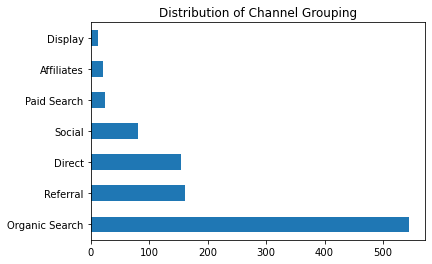

In [40]:
channel_df.channelGrouping.value_counts().plot(kind='barh')
plt.title('Distribution of Channel Grouping')
plt.show()

While it is interesting to see that majority of users find products via organic search, we only care about customer propensity once a visitor is in the marketplace and not customer journey, so we will not be using the __channelGrouping__ feature.

### Conclusion

In summary and based on our thorough examination of each feature, the column that will be most useful in creating our features and labels will be the __totals__ column in the next notebook.